# MPO Order Optimisation

Here, we test an order optimisation algorithm for the MPO application. The algorithm used is based on the matrix bandwidth minimisation technique.

In [1]:
import time
import numpy as np
from tqdm import tqdm
import qecstruct as qec
import matplotlib.pyplot as plt
from mdopt.optimiser.utils import (
    ConstraintString,
    IDENTITY,
    SWAP,
    XOR_BULK,
    XOR_LEFT,
    XOR_RIGHT,
)
from examples.decoding.decoding import (
    linear_code_parity_matrix_dense,
    linear_code_constraint_sites,
    linear_code_prepare_message,
    linear_code_codewords,
    linear_code_checks,
)
from examples.decoding.decoding import (
    apply_bitflip_bias,
    apply_constraints,
    decode_message,
)
from mdopt.mps.utils import (
    create_simple_product_state,
    create_custom_product_state,
)
from mdopt.utils.utils import mpo_to_matrix

In [2]:
def run_experiments(system_size, strategy):
    max_bond_dims = []
    max_entropies = []

    start_time = time.time()

    for _ in tqdm(range(NUM_EXPERIMENTS)):
        SEED = np.random.randint(1, 10**8)  # Use a new seed for each experiment
        rng = np.random.default_rng(SEED)

        NUM_CHECKS = int(
            3 * system_size / 4
        )  # Adjusted for BIT_DEGREE / CHECK_DEGREE = 3 / 4
        code = qec.random_regular_code(system_size, NUM_CHECKS, 3, 4, qec.Rng(SEED))
        code_constraint_sites = linear_code_constraint_sites(code)

        initial_codeword, perturbed_codeword = linear_code_prepare_message(
            code, PROB_ERROR, error_model=qec.BinarySymmetricChannel, seed=SEED
        )

        perturbed_codeword_state = create_custom_product_state(
            perturbed_codeword, form="Right-canonical"
        )
        perturbed_codeword_state = apply_bitflip_bias(
            perturbed_codeword_state, "All", PROB_BIAS, True
        )
        perturbed_codeword_state, entropies, bond_dims = apply_constraints(
            mps=perturbed_codeword_state,
            strings=code_constraint_sites,
            logical_tensors=[XOR_LEFT, XOR_BULK, SWAP, XOR_RIGHT],
            chi_max=CHI_MAX_CONTRACTOR,
            renormalise=True,
            result_to_explicit=False,
            strategy=strategy,
            silent=True,
            return_entropies_and_bond_dims=True,
        )

        max_bond_dims.append(np.max(bond_dims))
        max_entropies.append(np.max(np.abs(entropies)))

    end_time = time.time()
    elapsed_time = end_time - start_time

    return (
        np.mean(max_bond_dims),
        np.std(max_bond_dims),
        np.mean(max_entropies),
        np.std(max_entropies),
        elapsed_time,
    )

In [3]:
# Define the system sizes to be considered
system_sizes = [4, 8, 12, 16, 20, 24]

# Constants
CHI_MAX_CONTRACTOR = 1e4
PROB_ERROR = 0.15
PROB_BIAS = PROB_ERROR
NUM_EXPERIMENTS = 50

# Strategy settings
strategies = ["Naive", "Optimised"]

In [4]:
results = {
    strat: {
        "max_bond_dims": [],
        "bond_dims_err": [],
        "max_entropies": [],
        "entropy_err": [],
        "compute_times": [],
    }
    for strat in strategies
}

for strategy in strategies:
    for size in system_sizes:
        mean_bond_dim, std_bond_dim, mean_entropy, std_entropy, compute_time = (
            run_experiments(size, strategy)
        )
        results[strategy]["max_bond_dims"].append(mean_bond_dim)
        results[strategy]["bond_dims_err"].append(std_bond_dim)
        results[strategy]["max_entropies"].append(mean_entropy)
        results[strategy]["entropy_err"].append(std_entropy)
        results[strategy]["compute_times"].append(compute_time)

100%|██████████| 50/50 [13:48<00:00, 16.57s/it]


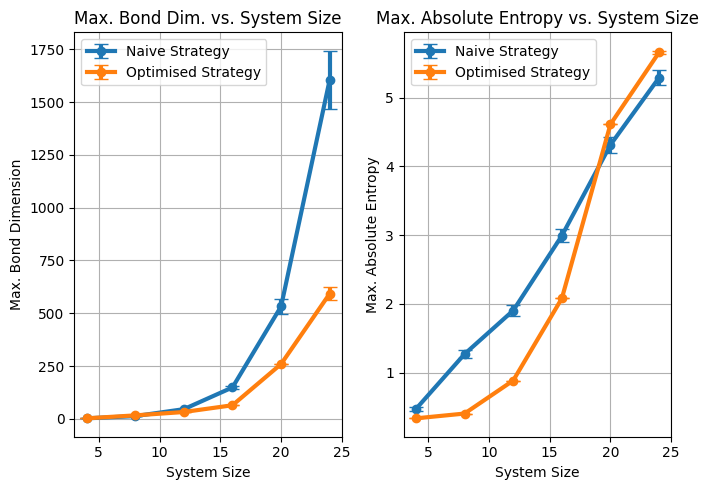

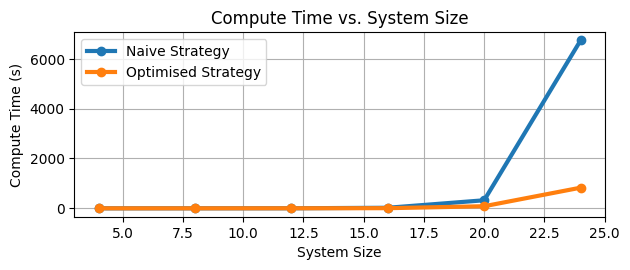

In [5]:
plt.figure(figsize=(7, 5))

plt.subplot(1, 2, 1)
for strategy in strategies:
    plt.errorbar(
        system_sizes,
        results[strategy]["max_bond_dims"],
        yerr=results[strategy]["bond_dims_err"] / (np.sqrt(NUM_EXPERIMENTS)),
        label=f"{strategy} Strategy",
        fmt="-o",
        capsize=5,
        linewidth=3,
    )
plt.xlabel("System Size")
plt.ylabel("Max. Bond Dimension")
plt.title("Max. Bond Dim. vs. System Size")
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
for strategy in strategies:
    plt.errorbar(
        system_sizes,
        results[strategy]["max_entropies"],
        yerr=results[strategy]["entropy_err"] / (np.sqrt(NUM_EXPERIMENTS)),
        label=f"{strategy} Strategy",
        fmt="-o",
        capsize=5,
        linewidth=3,
    )
plt.xlabel("System Size")
plt.ylabel("Max. Absolute Entropy")
plt.title("Max. Absolute Entropy vs. System Size")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

plt.subplot(2, 1, 1)
for strategy in strategies:
    plt.plot(
        system_sizes,
        results[strategy]["compute_times"],
        label=f"{strategy} Strategy",
        marker="o",
        linestyle="-",
        linewidth=3,
    )
plt.xlabel("System Size")
plt.ylabel("Compute Time (s)")
plt.title("Compute Time vs. System Size")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()